# PaMoDaCo: Working with measurements and model output

---

## Overview
Measurements coverage is inherently much sparser than that provided by model output, but a few data points spread over a geographic region can help shed light on how well a model may be simulating major trends in variable distributions, and in turn, model distributions can provide context for measured values. In this notebook we'll plot $\varepsilon$Nd data from a compilation by Poppelmeier et al, 2021 on top of $\varepsilon$Nd spatial distributions produced as part of the C-iTRACE simulation. At the end of this notebook, we'll take a brief look at whether the value measured in sediments at a particular latitude-longitude is unique to that location in the water column what that might say about the the local watermass geometry.

---

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import intake
import numpy as np
import xarray as xr
import os
import pandas as pd

import cftime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

from pathlib import Path

In [2]:
import sys
module_path = str(Path(os.getcwd()).parent.parent/'support_functions') 
if module_path not in sys.path:
    sys.path.append(module_path)

import data_processing as dp
import plotting_helpers as ph 

In [3]:
lat_u = r'$^{\circ}$N'
lon_u = r'$^{\circ}$E'
depth_u = 'm'
time_u = 'ky BP'
eNd_label = r'$\varepsilon$Nd'

## Load Data

### C-iTRACE
We'll start by loading some model output of neodymium isotopes from C-iTRACE, calculating $\varepsilon$Nd and selecting a slice to work with.

In [4]:
import fsspec

url = 'https://g-f750ca.a78b8.36fe.data.globus.org/C-iTRACE/ctrace.decadal.ND143.zarr'
mapper = fsspec.get_mapper(url)
ds = xr.open_zarr(mapper)

url = 'https://g-f750ca.a78b8.36fe.data.globus.org/C-iTRACE/ctrace.decadal.ND144.zarr'
ds = ds.merge(xr.open_zarr(fsspec.get_mapper(url)))


In [5]:
time_slice = slice(-8, -5)
epsNd_ds = ds.sel(dict(time=time_slice)).copy()

In [6]:
epsNd_tmp = xr.apply_ufunc(dp.epsNd, (epsNd_ds['ND143'],epsNd_ds['ND144']))
epsNd_tmp.name = 'eNd'

In [7]:
epsNd_ds['eNd'] = (('time', "z_t","nlat", "nlon"), epsNd_tmp.squeeze().data)
epsNd_ds = epsNd_ds.drop_vars(['ND143', 'ND144'])

In [8]:
# convert depth from cm to m
epsNd_ds = dp.convert_z_to_meters(epsNd_ds)
epsNd_ds

<xarray.Dataset>
Dimensions:     (nlat: 116, nlon: 100, time: 301, d2: 2, z_t_m: 60)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(116, 100), meta=np.ndarray>
  * time        (time) float64 -8.0 -7.99 -7.98 -7.97 ... -5.03 -5.02 -5.01 -5.0
    z_t         (z_t_m) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_m       (z_t_m) float32 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    time_bound  (time, d2) float64 dask.array<chunksize=(301, 2), meta=np.ndarray>
    eNd         (time, z_t_m, nlat, nlon) float32 dask.array<chunksize=(250, 8, 15, 25), meta=np.ndarray>
Attributes: (12/16)
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    calendar:                   All years have exactly  365 days.
    cell_methods:               cell_methods = time: mean ==> the variable va...
    contents:                   Diagnostic and Prognostic Variables
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    ...                         ...
    revision:                    $Name: ccsm3_0_1_beta22 $
    source:                     POP, the NCAR/CSM Ocean Component
    start_time:                 This dataset was created on 2007-07-29 at 23:...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    title:                      b30.22_0kaDVT

### Poppelemeier et al, 2021
Additionally, let's load data from Poppelemeier et al, 2021. This dataset covers LGM and Holocene $\varepsilon$Nd values. 

In [9]:
data_dir_path = Path(os.getcwd()).parent.parent/'data'

In [10]:
e_nd_csv = pd.read_csv(data_dir_path/'Poppelemeier2019_TableS3.csv', skiprows=2)


In [11]:
eNd_df = e_nd_csv.dropna(subset=['lat', 'lon'])#.drop(index=[0, 283])
eNd_df = eNd_df.apply(pd.to_numeric, errors='ignore').fillna(eNd_df)
eNd_df['lon'] = eNd_df['lon'].apply(lambda x: dp.lon_180_to_360(x))

eNd_df['z_t'] = eNd_df['depth'].astype(float)#*1000
eNd_df.head()

,Core,lat,lon,depth,eNd_HOL,eNd_LGM,eNd_LGM_M_HOL,Reference,Comment,z_t
1,M771/420,-15.2,284.4,516.0,-1.6,NaN,NaN,Ehlert2013,NaN,516.0
2,Pos_292_526_1,59.2,342.8,516.0,-13.1,NaN,NaN,Copard2010,NaN,516.0
3,Nd08_62309,40.4,292.3,522.0,-15.2,NaN,NaN,van de Flierdt2010,NaN,522.0
4,M771/554,-10.4,281.1,522.0,-1.5,NaN,NaN,Ehlert2013,NaN,522.0
5,M772/064_1,-1.9,278.8,529.0,2.2,NaN,NaN,Ehlert2013,NaN,529.0


In [12]:
time_var = 'eNd_HOL'
time_subset = eNd_df[~eNd_df[time_var].isna()]

Let's plot the depths of the samples, which also gives us a sense of the distribution.

In [14]:
n_levels= 60
min_lim= time_subset['depth'].min()
max_lim = time_subset['depth'].max()
ax2_levels = np.around(np.linspace(min_lim, max_lim, n_levels), decimals=4)
# make scalar mappable
ax2_sm = ph.make_scalar_mappable([min_lim, max_lim],'viridis_r' , n_levels)
cf2_kwargs = {'cmap':ax2_sm.cmap,'levels':ax2_levels, 'norm' : ax2_sm.norm}

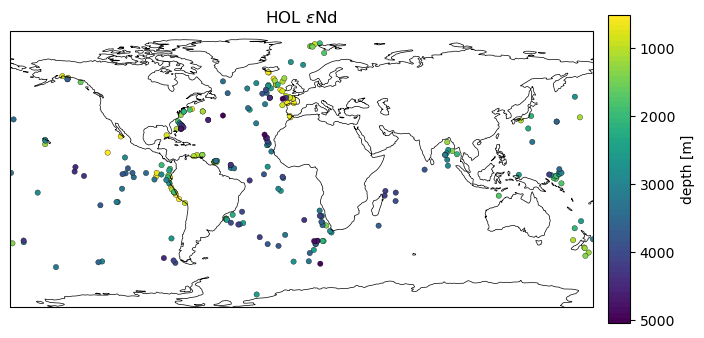

In [15]:
fig = plt.figure(figsize=(8, 4))
data_proj = ccrs.PlateCarree()
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=data_proj)

ax2.scatter(time_subset['lon'], time_subset['lat'], c=time_subset['depth'],s=15, 
                cmap=cf2_kwargs['cmap'], norm=cf2_kwargs['norm'],
                edgecolors='k',linewidth=.23, transform=data_proj)
    
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)
ax2.set_title('{} {}'.format(time_var.split('_')[1], eNd_label));

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label='depth [{}]'.format(depth_u),
                   format=FormatStrFormatter('%g'))
cb2.ax.invert_yaxis()

## Surface with Scatter
We'll grab a surface at a time within the Poppelemeier data and build a `pmeshcolor` figure that corresponds to 2000m.

In [16]:
var = 'eNd'
colorbar_units=eNd_label
traits = 'depth={} '+depth_u+ ', time={} '+time_u
time = 5.99
depth = 2000

In [17]:
c_snapshot_data = epsNd_ds.sel(time = -time, method='nearest')
c_snapshot_data_surf=c_snapshot_data.sel(dict(z_t_m=depth), method='nearest')

c_snapshot_data_surf = c_snapshot_data_surf[var].squeeze()
c_snapshot_data_surf = c_snapshot_data_surf.compute()

/Users/jlanders/opt/miniconda3/envs/pyleoclim_dev_sphinx/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [18]:
c_snapshot_data_surf

<xarray.DataArray 'eNd' (nlat: 116, nlon: 100)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    TLAT     (nlat, nlon) float64 -79.5 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    TLONG    (nlat, nlon) float64 323.3 326.9 330.5 334.1 ... 317.8 319.3 320.8
    time     float64 -5.99
    z_t      float32 1.969e+05
    z_t_m    float32 1.969e+03
Dimensions without coordinates: nlat, nlon

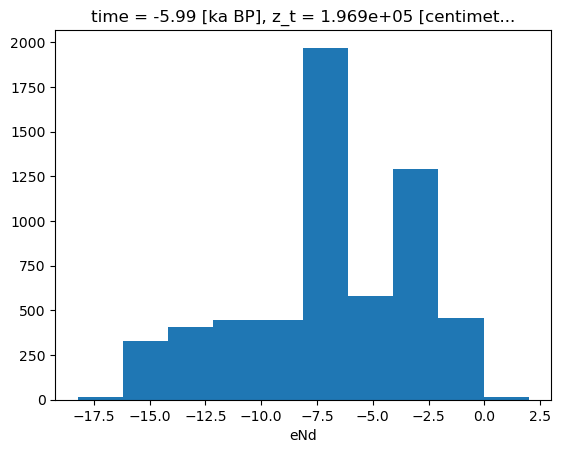

In [19]:
bins =c_snapshot_data_surf.plot.hist()
bin_edges = bins[1]

In [20]:
# establish scale
max_lim = bin_edges[-1]#c_snapshot_data.max()
min_lim = bin_edges[0]#c_snapshot_data.min()

In [21]:
n_levels= 60
ax2_levels = np.around(np.linspace(min_lim, max_lim, n_levels), decimals=4)
# make scalar mappable
ax2_sm_eNd = ph.make_scalar_mappable([min_lim, max_lim],['red', 'blue'] , n_levels)
cf2_kwargs_eNd = {'cmap':ax2_sm_eNd.cmap,'levels':ax2_levels, 'norm' : ax2_sm_eNd.norm}


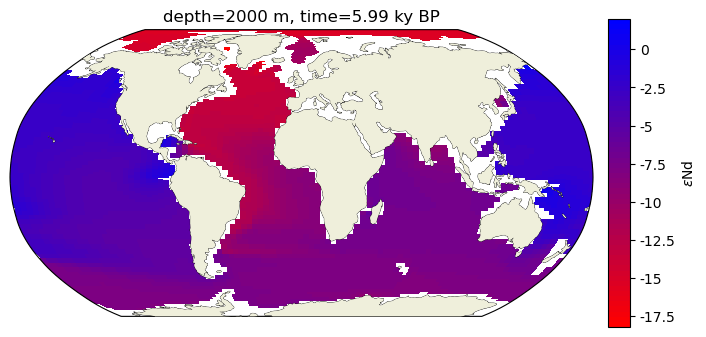

In [22]:
# plt.figure(figsize=(9,5));
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))

c_snapshot_data_surf.plot.pcolormesh(ax=ax2, 
                                   transform=ccrs.PlateCarree(), 
                                   x='TLONG', y='TLAT', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs_eNd['cmap'], 
                                  norm=cf2_kwargs_eNd['norm'], 
                                  add_colorbar=False);

ax2.coastlines(linewidth=.5)
ax2.add_feature(cfeature.LAND, zorder=14)

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm_eNd,cax=ax2_cb, orientation='vertical',label=' '.join([colorbar_units]),
                   format=FormatStrFormatter('%g'))                  

ax2.set_title(traits.format(depth, time));

It's delightfully straightforward now that we have a colormap and normalization scheme to superimpose the empirical data with circles colored according to their $\varepsilon$Nd values! 

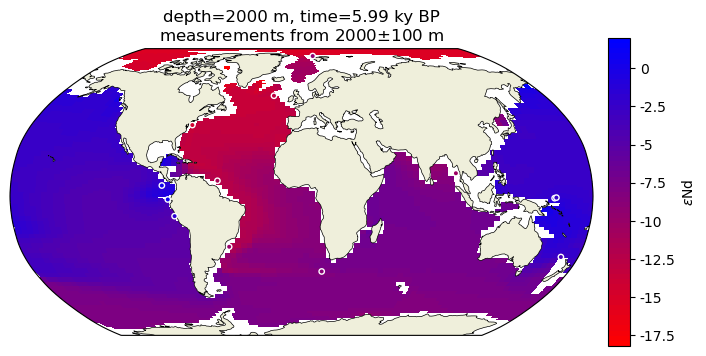

In [23]:
# plt.figure(figsize=(9,5));
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))

c_snapshot_data_surf.plot.pcolormesh(ax=ax2, 
                                   transform=ccrs.PlateCarree(), 
                                   x='TLONG', y='TLAT', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs_eNd['cmap'], 
                                  norm=cf2_kwargs_eNd['norm'], 
                                  add_colorbar=False)

# specifying `zorder=1` for the coatlines and land feature forces these map aspects to sit below the plotted point
ax2.add_feature(cfeature.LAND, zorder=1)
ax2.coastlines(linewidth=.5, zorder = 1)

surface_df = time_subset[time_subset['depth'].between(depth-100, depth+100)]
ax2.scatter(surface_df['lon'].apply(lambda x: dp.lon_180_to_360(x)), surface_df['lat'], c=surface_df['eNd_HOL'],s=15, 
                norm=cf2_kwargs_eNd['norm'],cmap=cf2_kwargs_eNd['cmap'],
                edgecolors='w',linewidth=1, transform=ccrs.PlateCarree())

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm_eNd,cax=ax2_cb, orientation='vertical',label=' '.join([colorbar_units]),
                   format=FormatStrFormatter('%g'))                  

ax2.set_title(traits.format(depth, time)+'\n'+r'measurements from {}$\pm$100 m'.format(depth));

## Section with Scatter
It is similarly straightforward to select a depth transect and then add the empirical data. The only challenge here is in selecting data. As noted in the py(?)ODV notebook, `sel` only works when data coordinates are one dimensional and correspond to dimsnsions. Here we want to select data along a line of longitude so we'll use a two condition `where` filter instead. The returned dataset will maintain its original coordinates, but with a mask applied to data variables.

In [24]:
def between(ds, var, lims):
    ds.coords[var] = ds.coords[var].compute()
    _ds = ds.where((ds.coords[var]<max(lims)) & (ds.coords[var]>min(lims)), drop=True)
    return _ds

In [25]:
lims = [340, 342]
section_ds = dp.between(c_snapshot_data, 'TLONG', lims)
section_df = time_subset[time_subset['lon'].between(min(lims), max(lims))]

In [26]:
tmp_surf = section_ds.sel(z_t_m=500, method='nearest')

In [27]:
n_levels= 60
ax2_levels = np.around(np.linspace(min_lim, max_lim, n_levels), decimals=4)
# make scalar mappable
ax2_sm_blank = ph.make_scalar_mappable([min_lim, max_lim],['darkblue', 'darkblue'] , n_levels)
cf2_kwargs_blank = {'cmap':ax2_sm_blank.cmap,'levels':ax2_levels, 'norm' : ax2_sm_blank.norm}


/Users/jlanders/opt/miniconda3/envs/pyleoclim_dev_sphinx/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


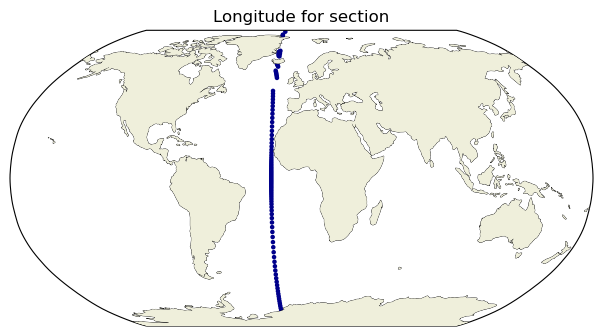

In [28]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

scatter = ax2.scatter(tmp_surf.TLONG,tmp_surf.TLAT,c=tmp_surf[var].squeeze(), transform=ccrs.PlateCarree(), 
             s=5, cmap=cf2_kwargs_blank['cmap'], norm=cf2_kwargs_blank['norm'])

ax2.add_feature(cfeature.LAND, zorder=14)
ax2.set_global()
ax2.set_title('Longitude for section');


def make_inset_map(ax, lats, lons, central_lon=0,central_lat=0, size_scaler=.25, loc="lower right"):
    axin = inset_axes(ax, width=size_scaler*5, height=size_scaler*5, loc=loc, 
                 axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                 axes_kwargs=dict(projection=ccrs.Orthographic(central_latitude=central_lat, 
                                                               central_longitude=central_lon)))
                                                               # central_lon)))

    axin.coastlines(linewidth=.5)
    axin.add_feature(cfeature.LAND, zorder=14)
    axin.plot(lons, lats, transform=ccrs.PlateCarree())
    axin.set_global()


/Users/jlanders/opt/miniconda3/envs/pyleoclim_dev_sphinx/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


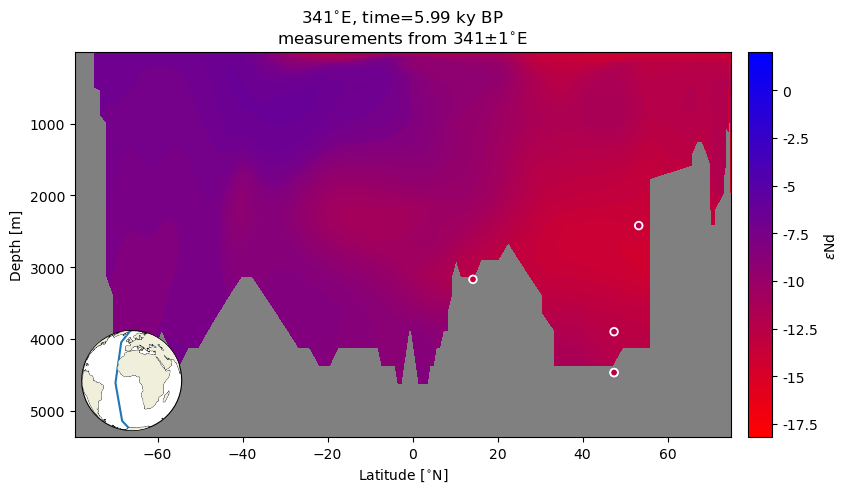

In [29]:
fig = plt.figure(figsize=(9,5));
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])
ax = fig.add_subplot(gs[0, 0]);
# tmp = query_latlon(ds, lats=None, lons=[None])
ax.patch.set_facecolor('gray')

ax.contourf(section_ds.TLAT.mean(dim='nlon'), section_ds.z_t_m,
                     section_ds[var].mean(dim='nlon').squeeze().data,10, origin='upper',
                         levels=ax2_levels,
                         cmap=ax2_sm_eNd.cmap, 
                        norm=ax2_sm_eNd.norm)

ax.scatter(section_df['lat'], section_df['depth'], c=section_df['eNd_HOL'],s=30, 
                norm=cf2_kwargs_eNd['norm'],cmap=cf2_kwargs_eNd['cmap'],
                edgecolors='w',linewidth=1.3)

ylims = ax.get_ylim()
ax.set_ylim([ylims[1], ylims[0]])
ax.set_ylabel('Depth [{}]'.format(depth_u))
ax.set_xlabel('Latitude [{}]'.format(lat_u))

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm_eNd,cax=ax2_cb, orientation='vertical',label=' '.join([colorbar_units]),
                   format=FormatStrFormatter('%g'))                  

ax.set_title('{}{}, time={} {}'.format(341, lon_u, time, time_u)+'\n'+r'measurements from {}$\pm$1'.format(341)+lon_u);

ph.make_inset_map(ax, [-90, 90], [341, 341], central_lon=0,central_lat=0, size_scaler=.2, loc='lower left')


Quite remarkable agreement between the Holocene empirical data and the model ouptut!

Note: The locations of measured data are subgrid resolution so it is not surprising to see plotted points floating above the land or seemingly below the surface of the seafloor.

### Uniqueness
As a thought experiment to close this notebook, let's assume the uncertainty on each $\varepsilon$Nd measurement is .2... What other depths at that location (latitude, longitude pair) have a value in that window? This should highlight a few points:
1. How many values in the water column are actually close to the measured value in that location? Color gives a broad sense of agreement, but can be challenging to interpret at a finer scale. 
2. In high latitude places with vertical transport, one would expect a somewhat more homogenous $\varepsilon$Nd across the water column.
3. In low and mid latitudes, one would expect the range to be more closely tied to a particular depth (which is to say, source region). 

In [30]:
lats = section_ds.TLAT.mean(dim='nlon').squeeze().data
data = section_ds[var].mean(dim='nlon').squeeze().data
depths = section_ds.z_t_m.data
section_ds_df = pd.DataFrame(data, columns=lats, index=depths)


/Users/jlanders/opt/miniconda3/envs/pyleoclim_dev_sphinx/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [31]:
depth_range_plot_d = {'lats':[], 'depth':[], 'eNd':[], 'source':[]} 
window = .3
for _,row in section_df.iterrows():
    try:
        profile_series = section_ds_df[lats[np.argwhere(lats>row['lat'])[0]-1]]#['eNd_HOL']
        # print(row['eNd_HOL'])
        uncertainty_range = profile_series.iloc[:,0][profile_series.iloc[:,0].between(row['eNd_HOL']-window, row['eNd_HOL']+window)]#profile_series.between(row['eNd_HOL']-.2, row['eNd_HOL']+.2)
        depth_range_plot_d['depth']+= uncertainty_range.index.values.tolist()
        depth_range_plot_d['depth'].append(row['depth'])
        depth_range_plot_d['lats'] +=[row['lat'] for ik in range(len(uncertainty_range))]
        depth_range_plot_d['lats'].append(row['lat'])
        depth_range_plot_d['eNd'] += uncertainty_range.values.ravel().tolist()
        depth_range_plot_d['eNd'].append(row['eNd_HOL'])
        depth_range_plot_d['source'] +=['model' for ik in range(len(uncertainty_range))]
        depth_range_plot_d['source'].append('measurement')
    except:
        print(row['Core'])

depth_range_plot_df = pd.DataFrame(depth_range_plot_d)

Now we'll add these points--outlined in black--to the section plot. This will provide some context for the distribution of eNd in the water column.

/Users/jlanders/opt/miniconda3/envs/pyleoclim_dev_sphinx/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


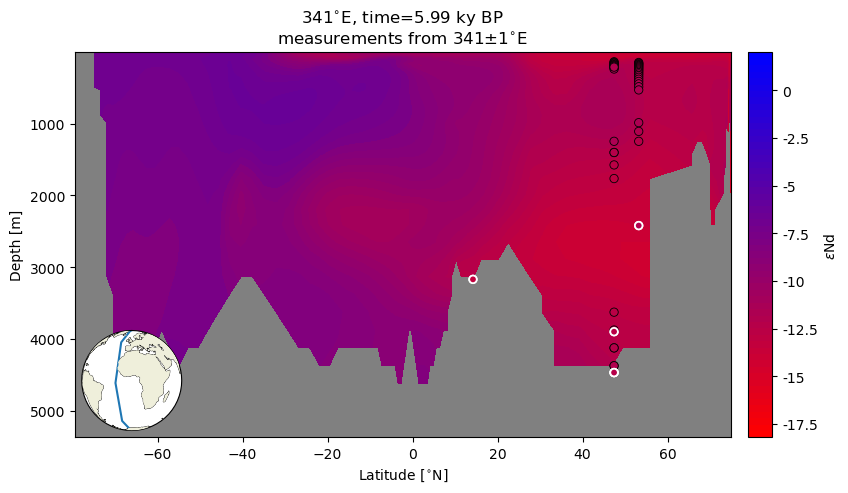

In [32]:
fig = plt.figure(figsize=(9,5));
gs = gridspec.GridSpec(1, 2, wspace=0.05,hspace=.05, width_ratios=[8, .3])
ax = fig.add_subplot(gs[0, 0]);
# tmp = query_latlon(ds, lats=None, lons=[None])
ax.patch.set_facecolor('gray')

ax.contourf(section_ds.TLAT.mean(dim='nlon'), section_ds.z_t_m,
                     section_ds[var].mean(dim='nlon').squeeze().data,10, origin='upper',
                         levels=ax2_levels,
                         cmap=ax2_sm_eNd.cmap, 
                        norm=ax2_sm_eNd.norm)
ax.scatter(depth_range_plot_df['lats'], depth_range_plot_df['depth'], c=depth_range_plot_df['eNd'], linewidth=.6,
           norm=cf2_kwargs_eNd['norm'],cmap=cf2_kwargs_eNd['cmap'],edgecolor=['k' if source=='model' else 'w' for source in depth_range_plot_df['source']])

ax.scatter(section_df['lat'], section_df['depth'], c=section_df['eNd_HOL'],s=30, 
                norm=cf2_kwargs_eNd['norm'],cmap=cf2_kwargs_eNd['cmap'],
                edgecolors='w',linewidth=1.3)

ylims = ax.get_ylim()
ax.set_ylim([ylims[1], ylims[0]])
ax.set_ylabel('Depth [{}]'.format(depth_u))
ax.set_xlabel('Latitude [{}]'.format(lat_u))

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm_eNd,cax=ax2_cb, orientation='vertical',label=' '.join([colorbar_units]),
                   format=FormatStrFormatter('%g'))                  

ax.set_title('{}{}, time={} {}'.format(341, lon_u, time, time_u)+'\n'+r'measurements from {}$\pm$1'.format(341)+lon_u);

ph.make_inset_map(ax, [-90, 90], [341, 341], central_lon=0,central_lat=0, size_scaler=.2, loc='lower left')


The choice of window was somewhat arbitrary, but this plot suggests that at high latitudes, there are model values at multiple locations in the water column that are within range of the measured values. In contrast, the window around the low latitude measurement does not appear to fall within the model range. 

---

## Resources and references

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|Gu, Sifan, Liu, Zhengyu, Jahn, Alexandra, Zanowski, Hannah. (2021). C-iTRACE. Version 1.0. UCAR/NCAR - DASH Repository. https://doi.org/10.5065/hanq-bn92. 
| Pöppelmeier, F., Gutjahr, M., Blaser, P., Schulz, H., Süfke, F., & Lippold, J. (2021). Stable Atlantic deep water mass sourcing on glacial-interglacial timescales. Geophysical Research Letters, 48, e2021GL092722. https://doi.org/10.1029/2021GL092722 